In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import acf, pacf

In [4]:
pip install pmdarima

  Using cached pmdarima-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.5 MB)
  Using cached Cython-0.29.17-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.19
    Uninstalling Cython-0.29.19:
      Successfully uninstalled Cython-0.29.19
Note: you may need to restart the kernel to use updated packages.


In [6]:
from pmdarima.arima import auto_arima

In [7]:
#import NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")

In [8]:
#understand data format and clean up data 
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2705, freq=None)

In [9]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [10]:
df.sample(5, random_state=0)


,Close,year,month,day
Date,,,,
2010-05-17,2354.229980,2010,5,17
2018-02-01,7385.859863,2018,2,1
2013-07-29,3599.139893,2013,7,29
2016-11-08,5193.490234,2016,11,8
2014-06-13,4310.649902,2014,6,13


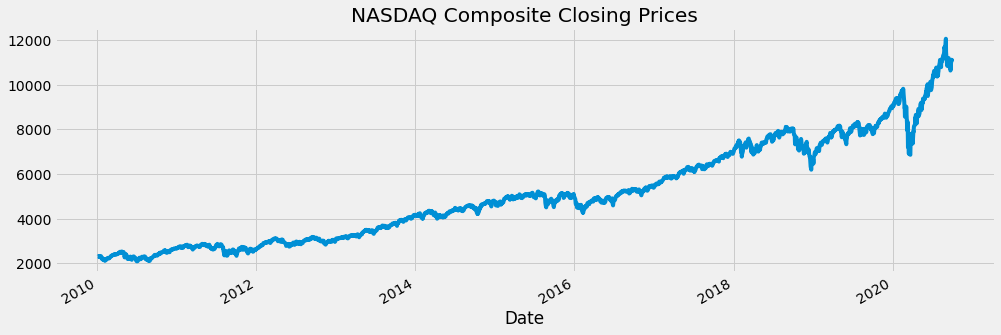

In [11]:
#plot NASDAQ trend 
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(15,5), title= 'NASDAQ Composite Closing Prices', fontsize=14)

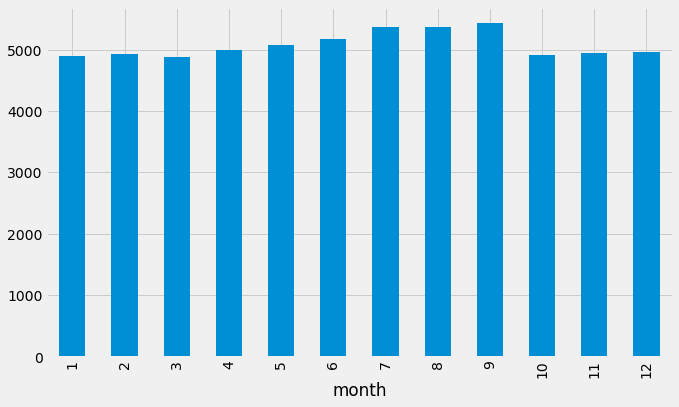

In [12]:
df.groupby('month')['Close'].mean().plot.bar()
#on average, september has the highest average price compares to the other months. 

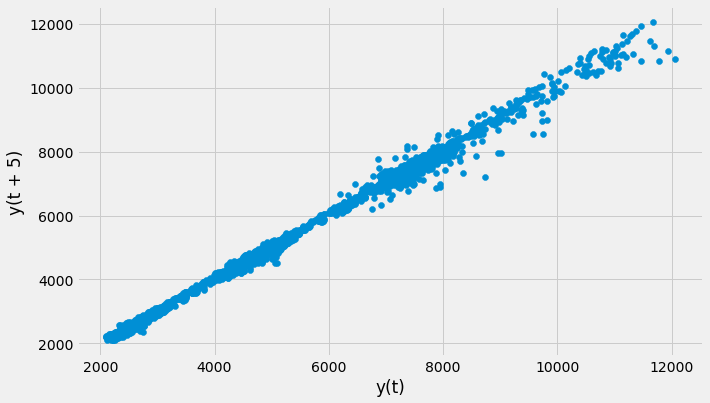

In [13]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)

#Graph shows a linear pattern. Implies data points are non random and suggests that an autoregressive model might be appropriate.

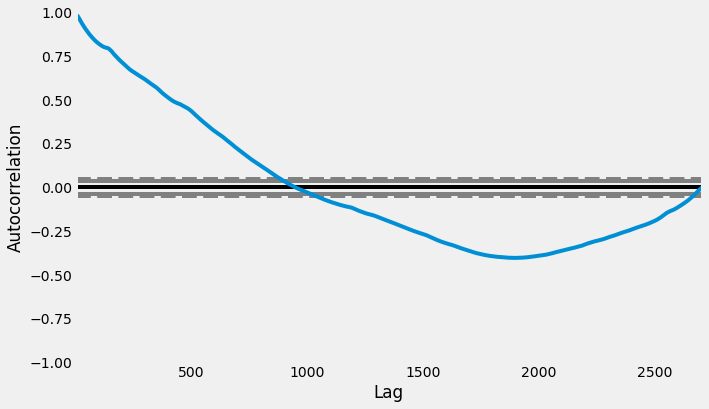

In [14]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#there is high level of correlation 

In [15]:
#data is not stationary based on high p value
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: 1.4430465972942679
p-value:0.9973011850493003


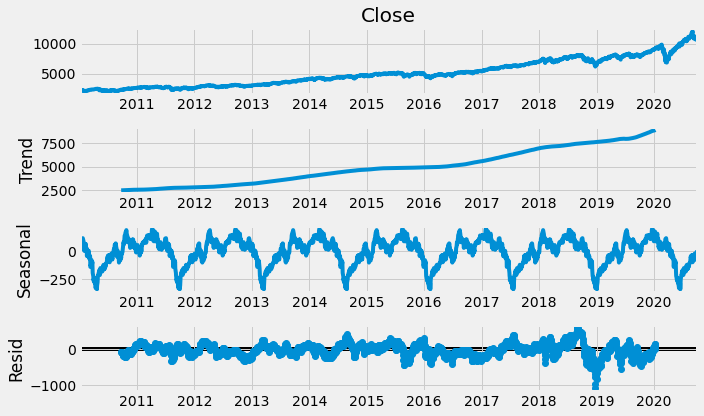

In [16]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#data shows upward trend and presents seasonlity

In [97]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=100):
    plt.plot(x,y)
    plt.show()

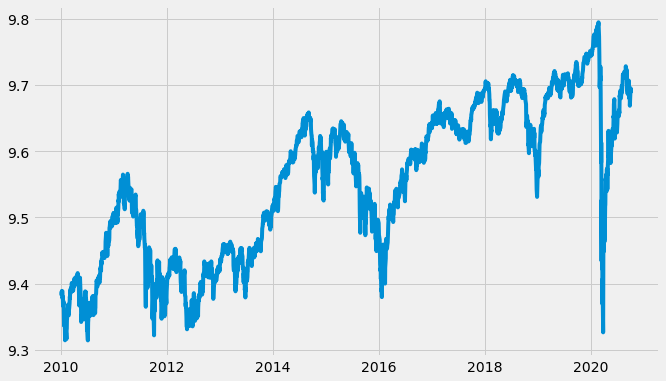

In [98]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

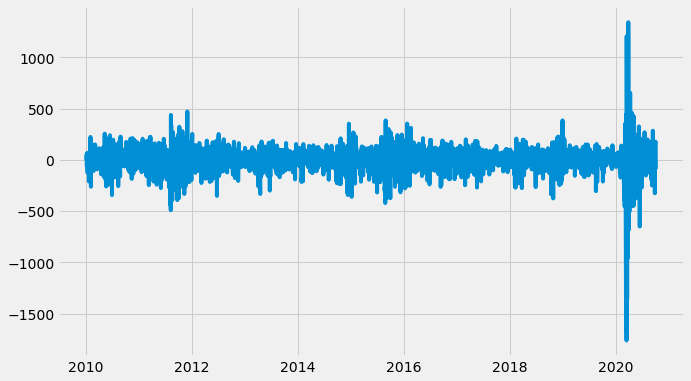

In [96]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [20]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -11.770291597674845
p-value:1.0940406662618215e-21


In [21]:
df_st= df.diff(1).fillna(0)

In [22]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.000000,0.0,0.0,0.0
2010-01-05,0.290039,0.0,0.0,1.0
2010-01-06,-7.619873,0.0,0.0,1.0
2010-01-07,-1.040039,0.0,0.0,1.0
2010-01-08,17.119873,0.0,0.0,1.0


In [23]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_reconstruct=df_st.copy()
df_resconstruct=df_reconstruct.cumsum()

In [24]:
df_reconstruct=df_st.copy()
df_reconstruct.iloc[0,:]=df.iloc[0,:]
df_reconstruct = df_reconstruct.cumsum()


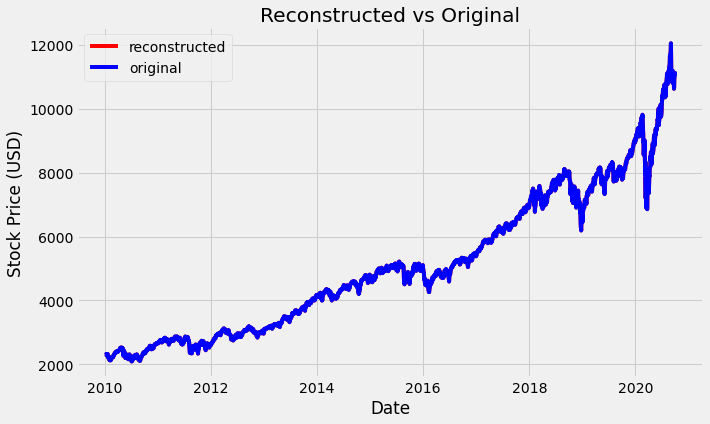

In [25]:
plt.plot(df.index, df_reconstruct['Close'], 'r-',  label='reconstructed')
plt.plot(df.index, df['Close'], 'b-', label = 'original')
plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Reconstructed vs Original')
plt.legend();
#plot confirms the same pattern of data

In [26]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.reconstructed = self.reconstruct(self.stationary, self.data)
        
    def reconstruct(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [27]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.9))])
x_valid = TimeSeriesData(df[int((len(df)*0.9)):])


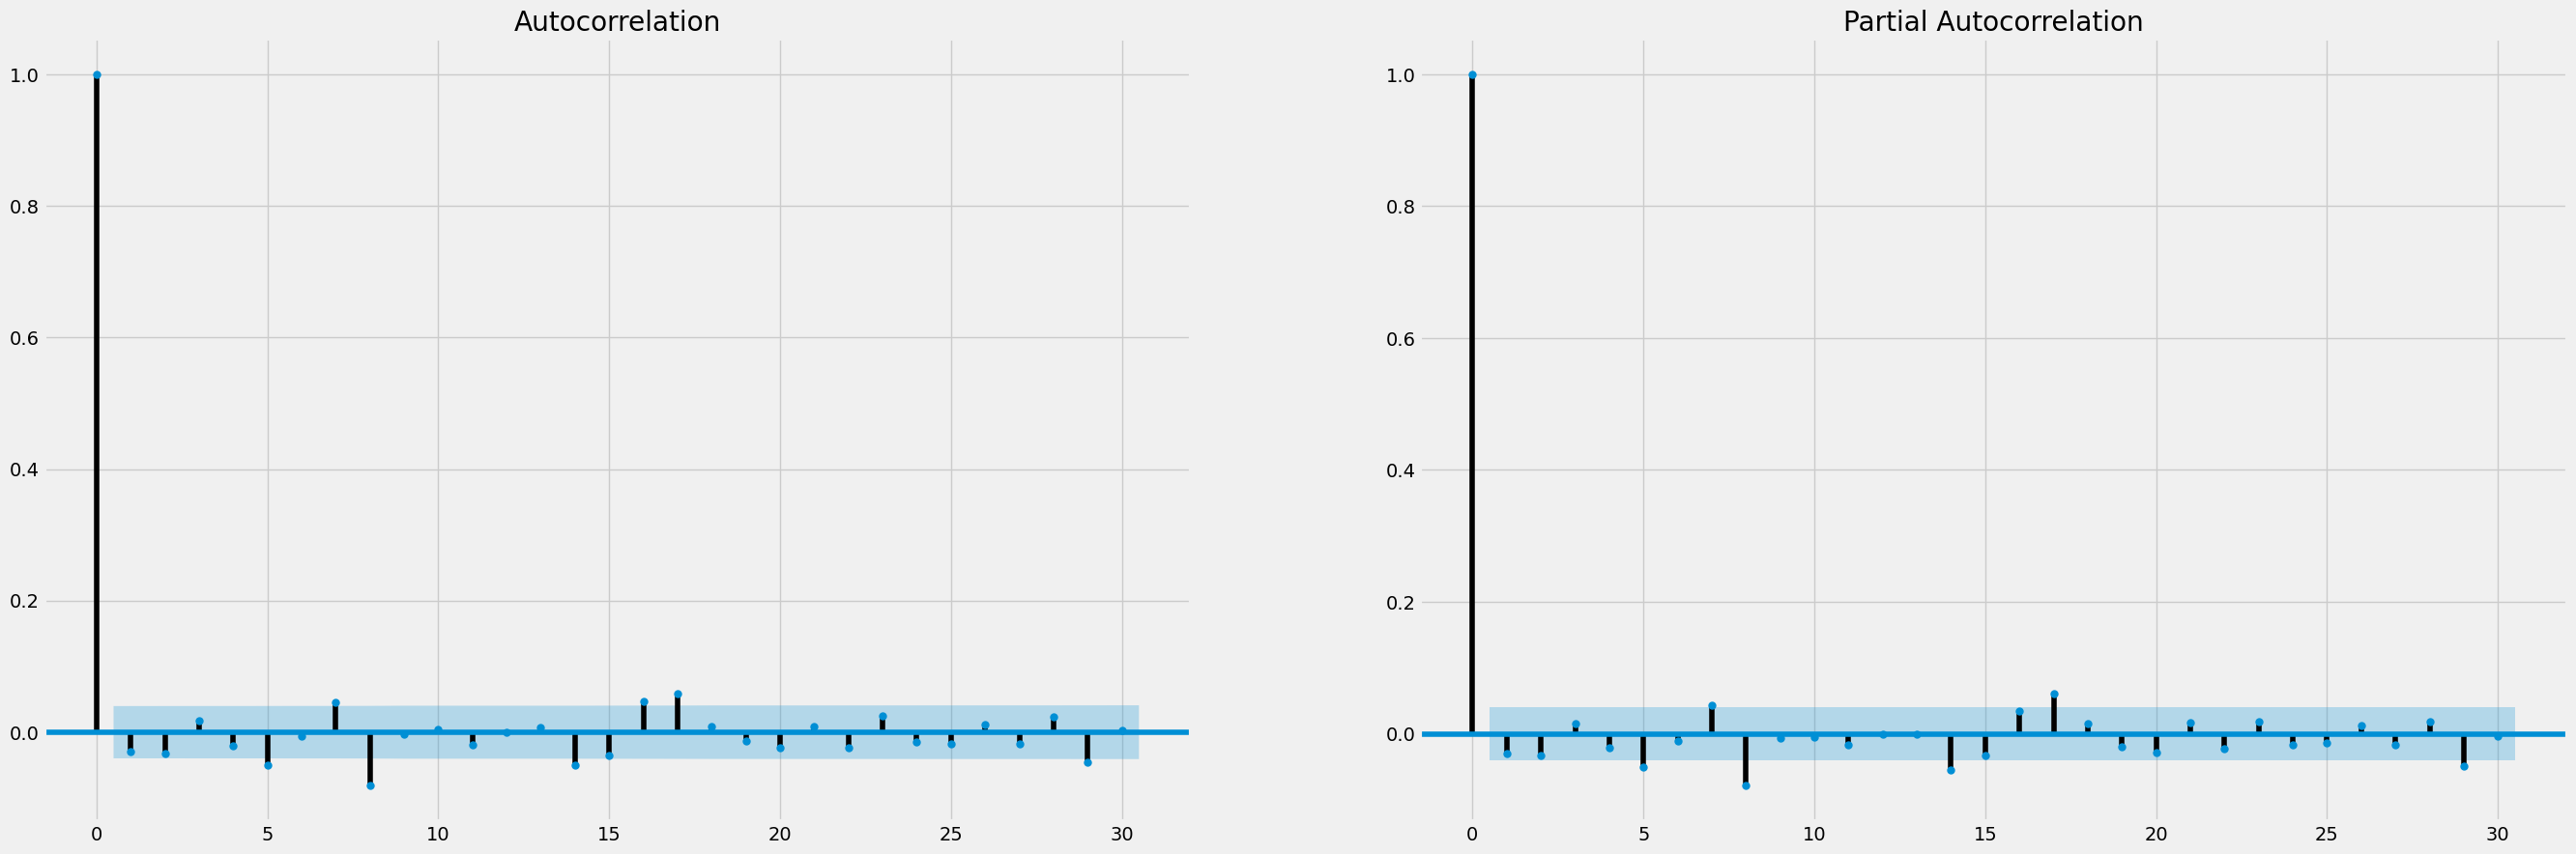

In [28]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[1]);

In [29]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26066.202, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26076.884, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26076.691, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26076.549, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26079.882, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26075.487, Time=2.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26075.648, Time=1.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26068.264, Time=3.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26068.512, Time=2.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26070.891, Time=1.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26079.396, Time=1.73 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26079.243, Time=1.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=26065.626, Time=4.68 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=26068.108, Time=4.90 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 5), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [30]:
model_arima = ARIMA(x_train.data['Close'].values, order=(3,1,5))

In [31]:
result_arima = model_arima.fit(disp=-1)

In [32]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2433
Model:                 ARIMA(3, 1, 5)   Log Likelihood              -13022.009
Method:                       css-mle   S.D. of innovations             51.074
Date:                Mon, 16 Nov 2020   AIC                          26064.018
Time:                        17:52:43   BIC                          26121.986
Sample:                             1   HQIC                         26085.092
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3632      0.574      4.119      0.000       1.239       3.488
ar.L1.D.y      0.2905      0.093      3.125      0.002       0.108       0.473
ar.L2.D.y     -0.2264      0.079     -2.873      0.0

In [33]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

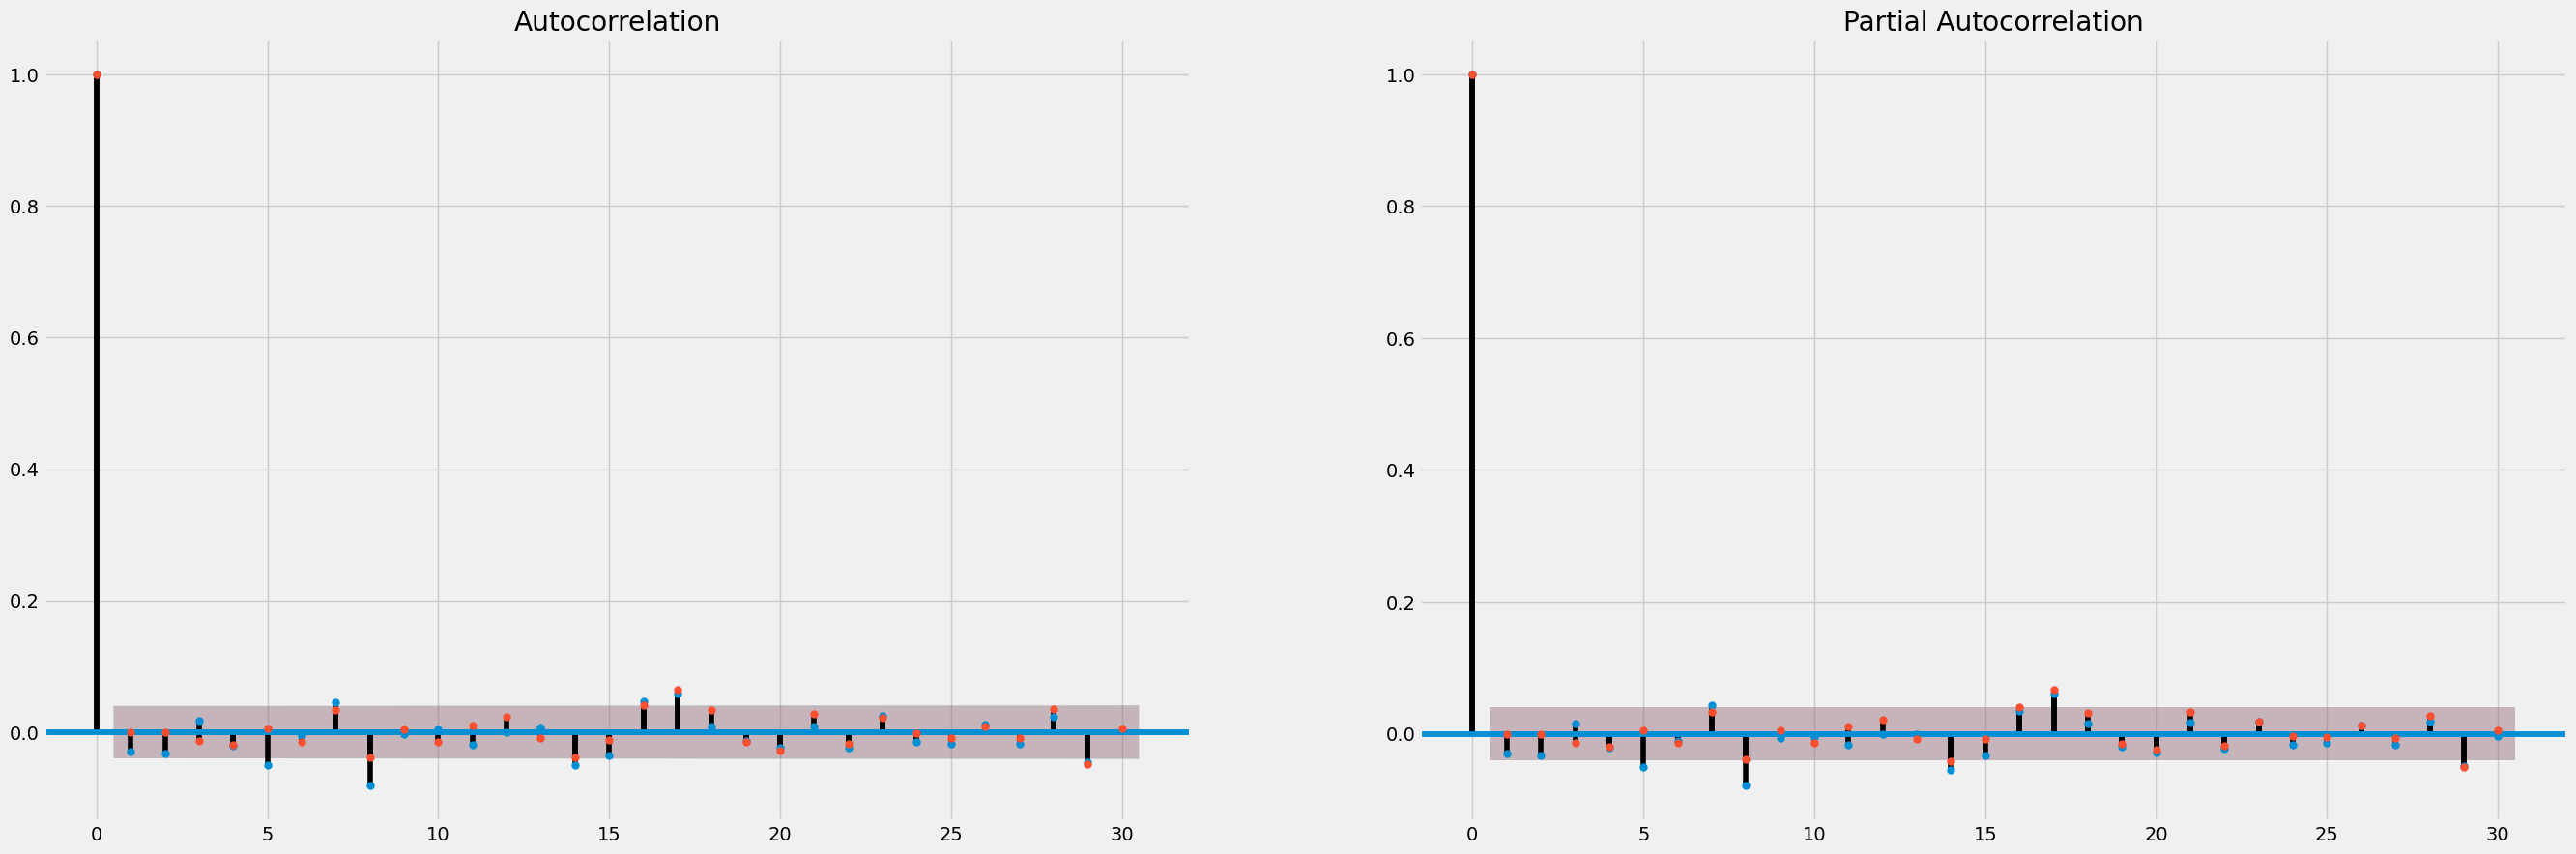

In [34]:
plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1])

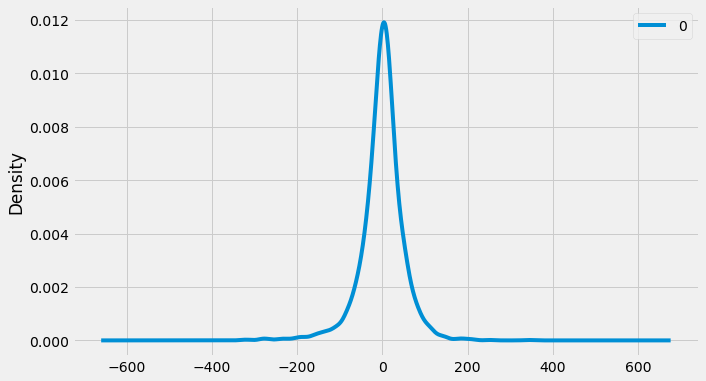

In [35]:
residuals.plot(kind='kde')

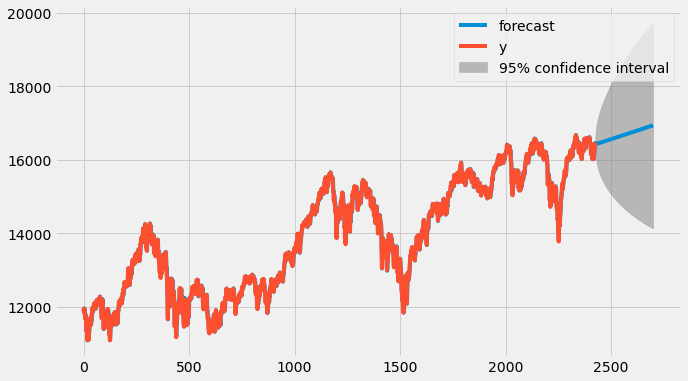

In [122]:
result_arima.plot_predict(1,2700);

In [81]:
prediction = result_arima.predict(len(df)-208,len(df)-1)
def rmse(validation, prediction):
    error = validation - prediction
    return np.sqrt(np.mean(error**2))

In [82]:
from statsmodels.tools.eval_measures import rmse 
#RMSE for ARIMA Model
err_LSTM = rmse(x_valid.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 1361.2487894244925


In [ ]:
#same analysis for TSX price

In [83]:
#upload TSX price
df=pd.read_csv("GSPTSE_v1.csv", sep=",")

In [84]:
#understand the data and covert date format
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2697, freq=None)

In [85]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [86]:
df.sample(5, random_state=0)

,Close,year,month,day
Date,,,,
2012-09-06,12139.70020,2012,9,6
2016-03-04,13212.50000,2016,3,4
2014-09-23,15125.70020,2014,9,23
2017-05-31,15349.90039,2017,5,31
2016-02-16,12555.00000,2016,2,16


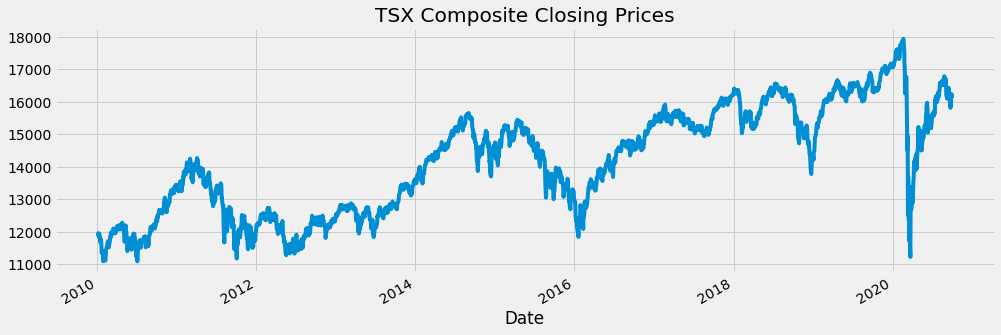

In [88]:
#plot TSX trend
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(15,5), title= 'TSX Composite Closing Prices', fontsize=14)

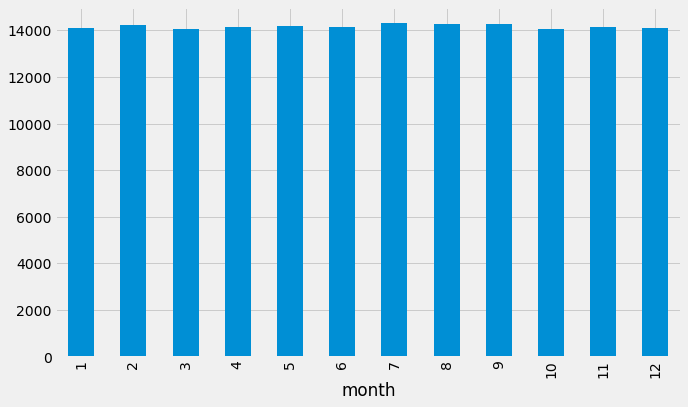

In [89]:
df.groupby('month')['Close'].mean().plot.bar()

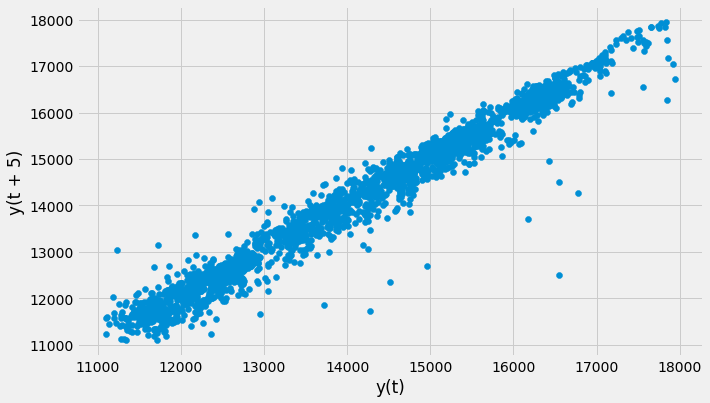

In [90]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)
#a linear plot also indicates non random dataset

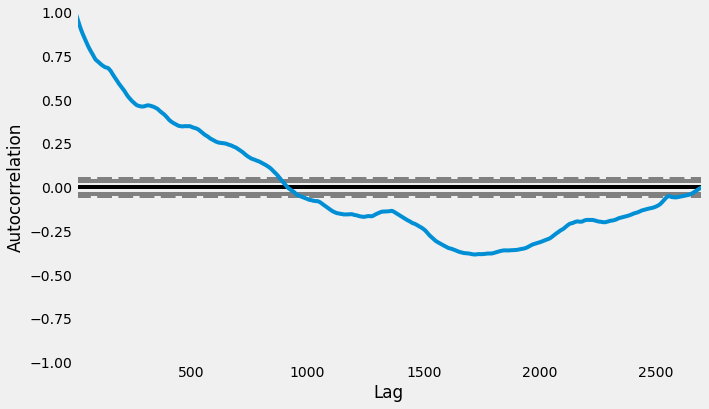

In [91]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#autocorrelation suggests arima might be a good model

In [92]:
#original data shows as not stationary due to high p level
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -2.1272017170757755
p-value:0.23371823999228158


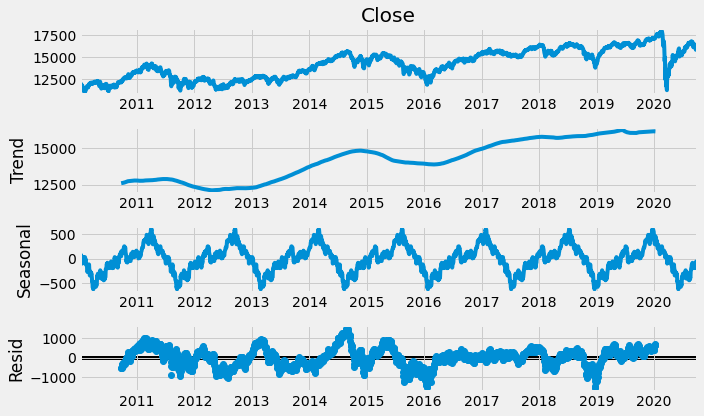

In [93]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#upward trend

In [100]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=100):
    plt.plot(x,y)
    plt.show()

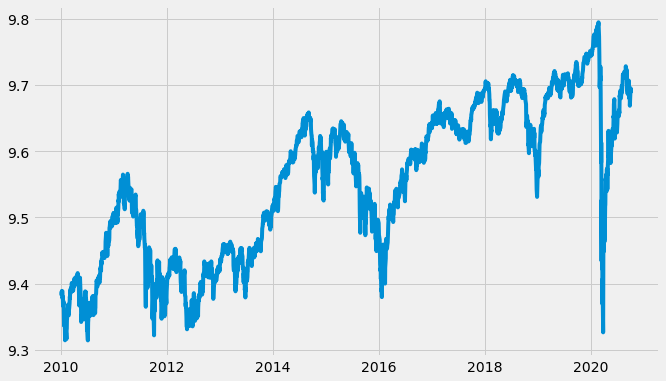

In [101]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

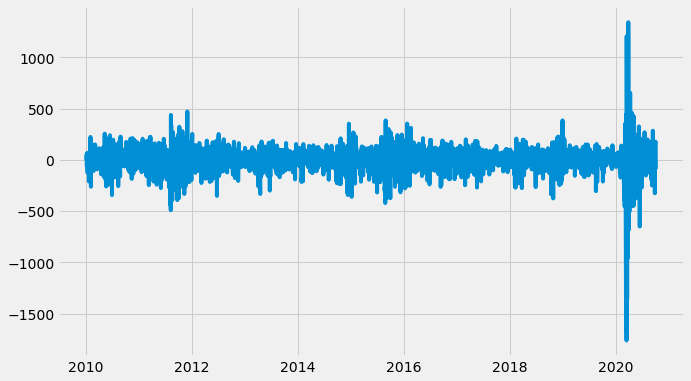

In [102]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [103]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -10.92108896454532
p-value:1.037610106877016e-19


In [104]:
df_st= df.diff(1).fillna(0)

In [105]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.00000,0.0,0.0,0.0
2010-01-05,21.19922,0.0,0.0,1.0
2010-01-06,56.40039,0.0,0.0,1.0
2010-01-07,-57.00000,0.0,0.0,1.0
2010-01-08,66.29981,0.0,0.0,1.0


In [106]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_reconstruct=df_st.copy()
df_resconstruct=df_reconstruct.cumsum()

In [107]:
df_reconstruct=df_st.copy()
df_reconstruct.iloc[0,:]=df.iloc[0,:]
df_reconstruct = df_reconstruct.cumsum()


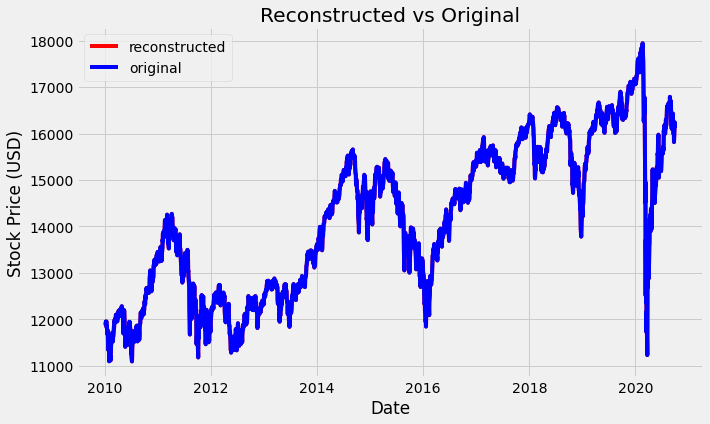

In [108]:
plt.plot(df.index, df_reconstruct['Close'], 'r-',  label='reconstructed')
plt.plot(df.index, df['Close'], 'b-', label = 'original')
plt.xlabel('Date'); plt.ylabel('Stock Price (USD)')
plt.title('Reconstructed vs Original')
plt.legend();
#plot confirms the same pattern of data

In [109]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.reconstructed = self.reconstruct(self.stationary, self.data)
        
    def reconstruct(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [110]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.9))])
x_valid = TimeSeriesData(df[int((len(df)*0.9)):])

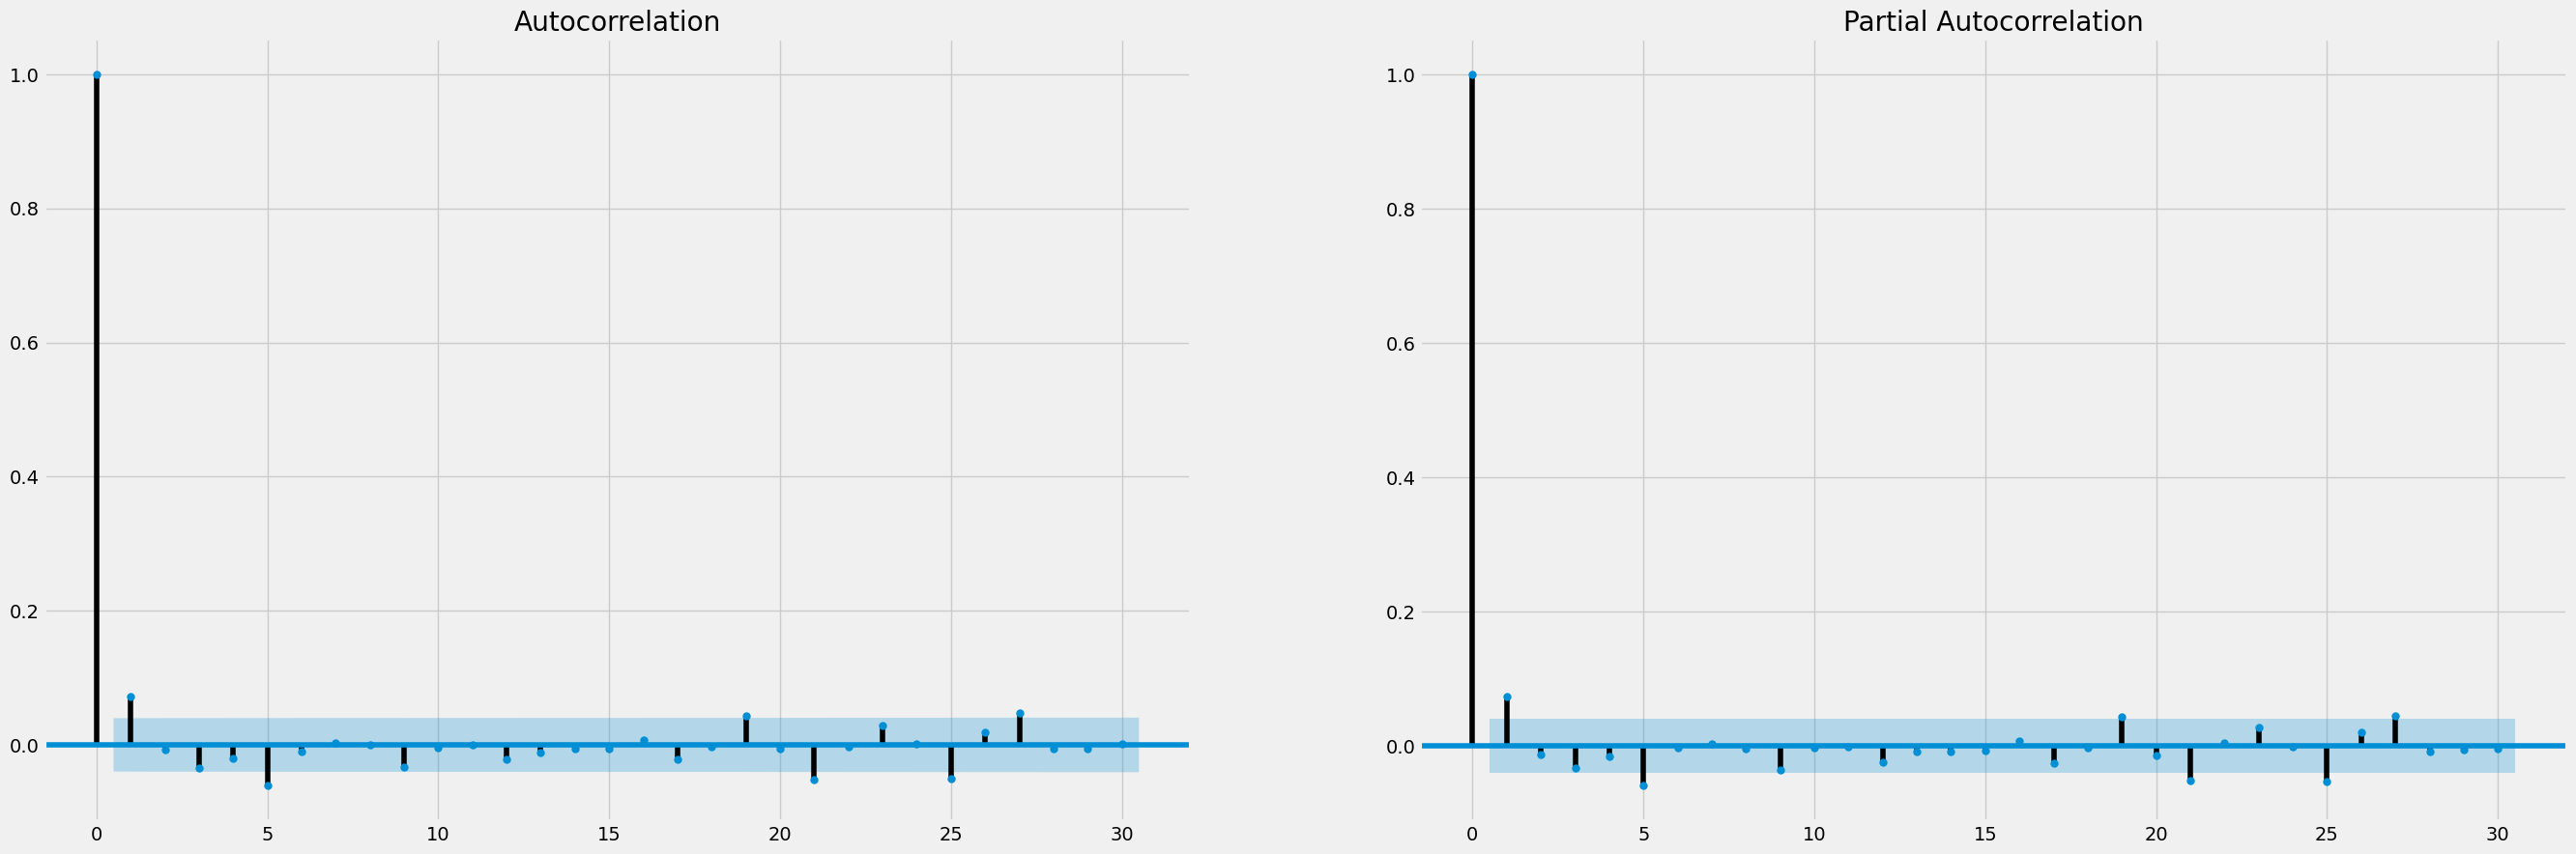

In [111]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[1]);

In [112]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29284.460, Time=3.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29299.150, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29288.301, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29288.102, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29297.992, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29284.372, Time=2.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=29290.093, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29290.101, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=29284.493, Time=1.98 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=29289.281, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29283.355, Time=2.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29289.908, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29284.421, Time=1.83 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=29289.212, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [113]:
model_arima = ARIMA(x_train.data['Close'].values, order=(2,1,1))

In [114]:
result_arima = model_arima.fit(disp=-1)

In [115]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2426
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14636.746
Method:                       css-mle   S.D. of innovations            100.921
Date:                Mon, 16 Nov 2020   AIC                          29283.491
Time:                        22:39:29   BIC                          29312.461
Sample:                             1   HQIC                         29294.025
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8895      1.741      1.085      0.278      -1.523       5.301
ar.L1.D.y      0.9539      0.059     16.248      0.000       0.839       1.069
ar.L2.D.y     -0.0924      0.020     -4.543      0.0

In [116]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

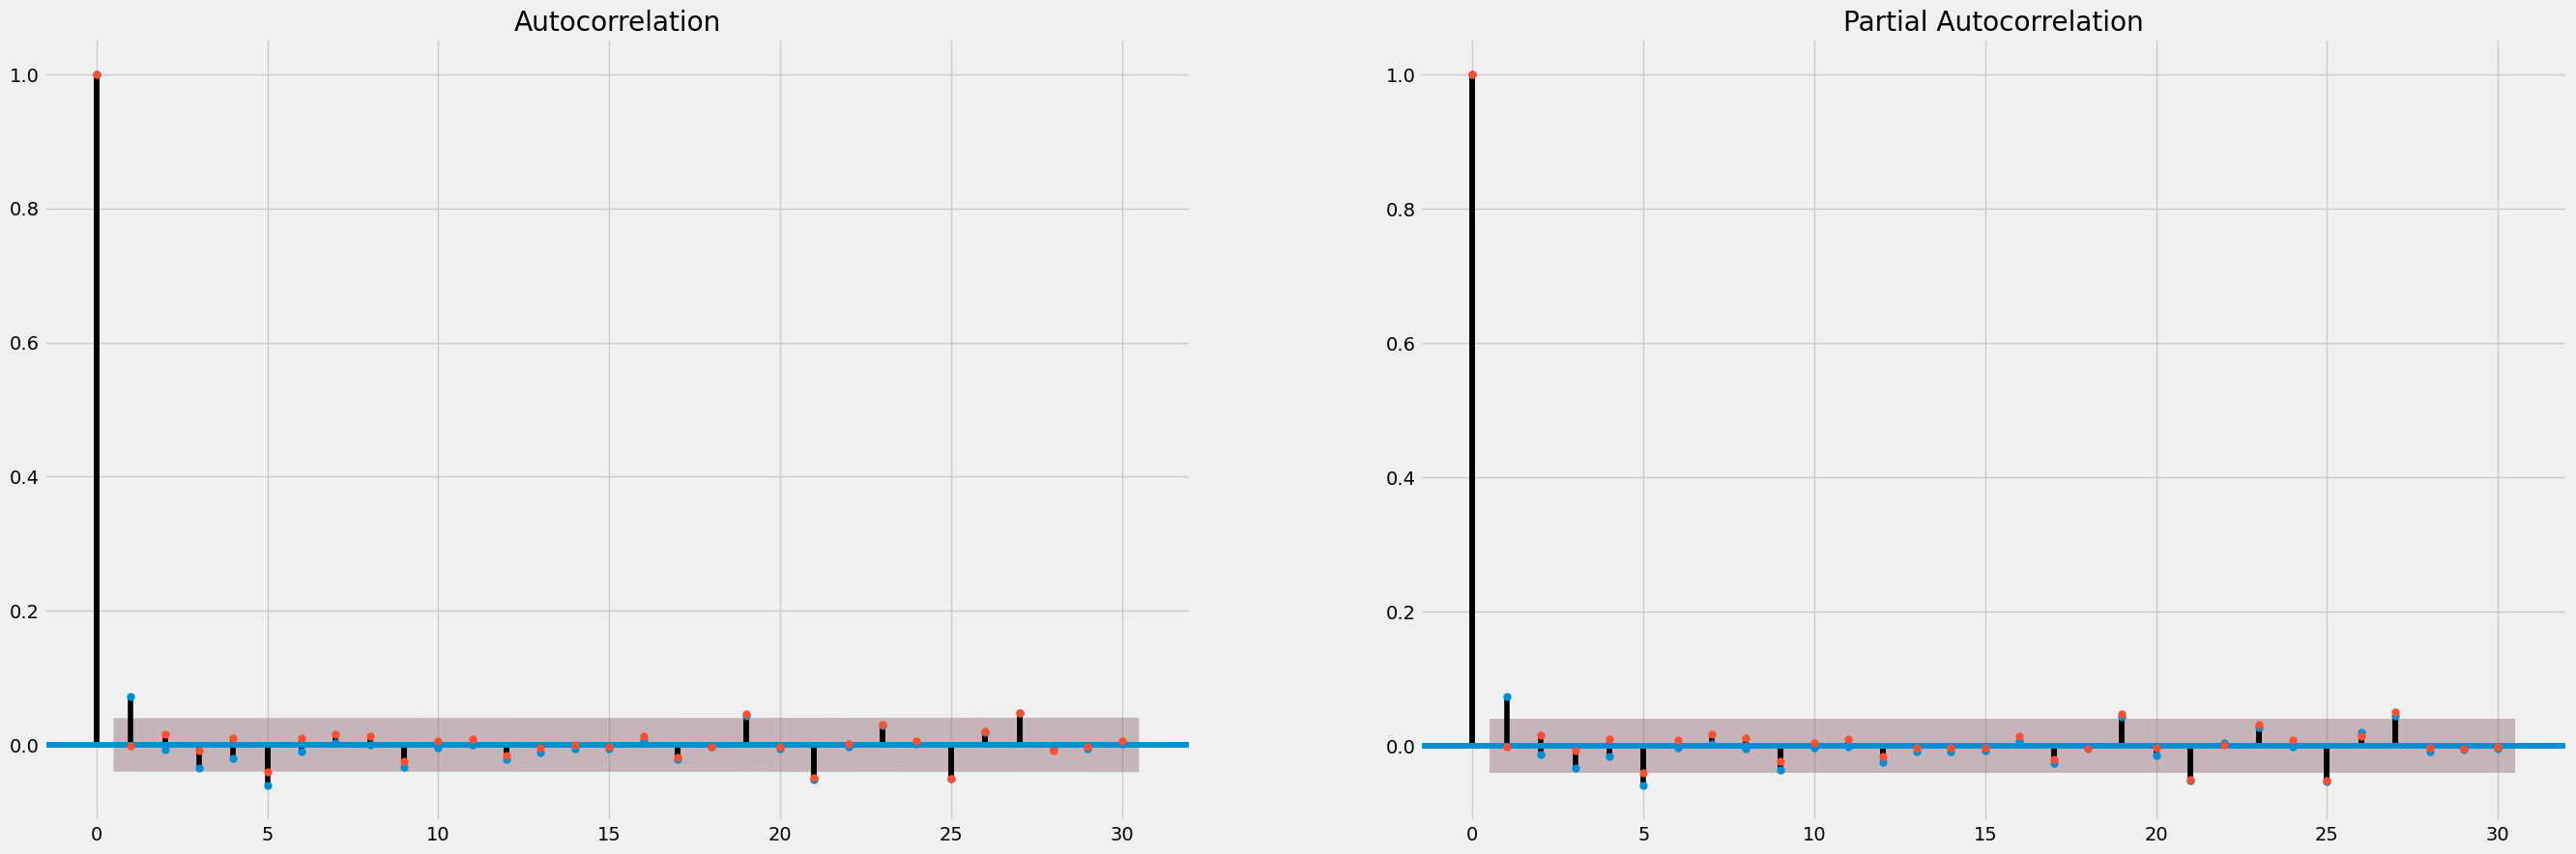

In [117]:
plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1])

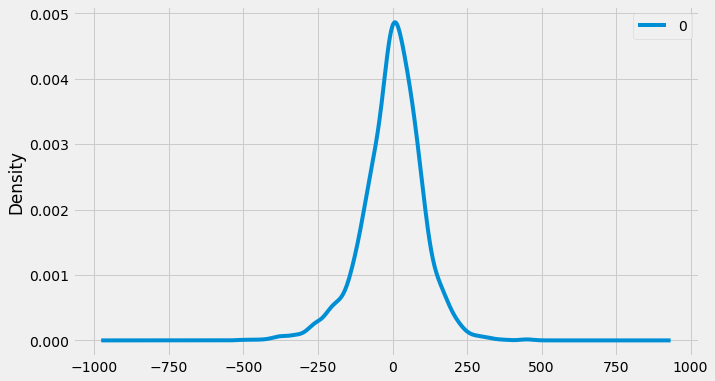

In [118]:
residuals.plot(kind='kde')

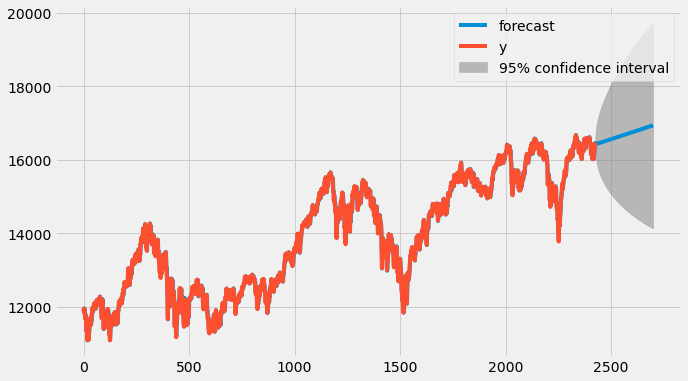

In [123]:
result_arima.plot_predict(1,2700);

In [120]:

prediction = result_arima.predict(len(df)-208,len(df)-1)
def rmse(validation, prediction):
    error = validation - prediction
    return np.sqrt(np.mean(error**2))

In [121]:
from statsmodels.tools.eval_measures import rmse 
#RMSE for ARIMA Model
err_LSTM = rmse(x_valid.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 1476.4252612252953


In [ ]:
#using LSTM to predict stock price

In [44]:
pip install tensorflow

  Using cached tensorflow-2.3.1-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached grpcio-1.33.2-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorboard-2.4.0-py3-none-any.whl (10.6 MB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-0.11.0-py3-none-any.whl (127 kB)
Processing ./.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2/termcolor-1.1.0-py3-none-any.whl
Processing ./.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6/wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached Werkzeug-1.0.1-py2.py3-none-any.whl (298 kB)
  Using cached Markdown-3.3.3-py3-none-a

In [45]:
pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [47]:
from pandas_datareader import data
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [48]:
#similar to before, upload NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [49]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [50]:
#scale and reshape data
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 2600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [51]:
#add layers
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [52]:
#add optimizer and build model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 35, batch_size = 30)


Epoch 1/35
85/85 [==============================] - 13s 148ms/step - loss: 0.0072
Epoch 2/35
85/85 [==============================] - 12s 144ms/step - loss: 0.0021
Epoch 3/35
85/85 [==============================] - 12s 144ms/step - loss: 0.0016
Epoch 4/35
85/85 [==============================] - 12s 143ms/step - loss: 0.0014
Epoch 5/35
85/85 [==============================] - 12s 141ms/step - loss: 0.0014
Epoch 6/35
85/85 [==============================] - 12s 138ms/step - loss: 0.0014
Epoch 7/35
85/85 [==============================] - 12s 139ms/step - loss: 0.0012
Epoch 8/35
85/85 [==============================] - 12s 138ms/step - loss: 0.0012
Epoch 9/35
85/85 [==============================] - 12s 141ms/step - loss: 0.0012
Epoch 10/35
85/85 [==============================] - 12s 139ms/step - loss: 0.0010
Epoch 11/35
85/85 [==============================] - 13s 151ms/step - loss: 0.0011
Epoch 12/35
85/85 [==============================] - 12s 136ms/step - loss: 0.0013
Epoch 13/35
8

In [70]:
#train the model
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 601):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [71]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


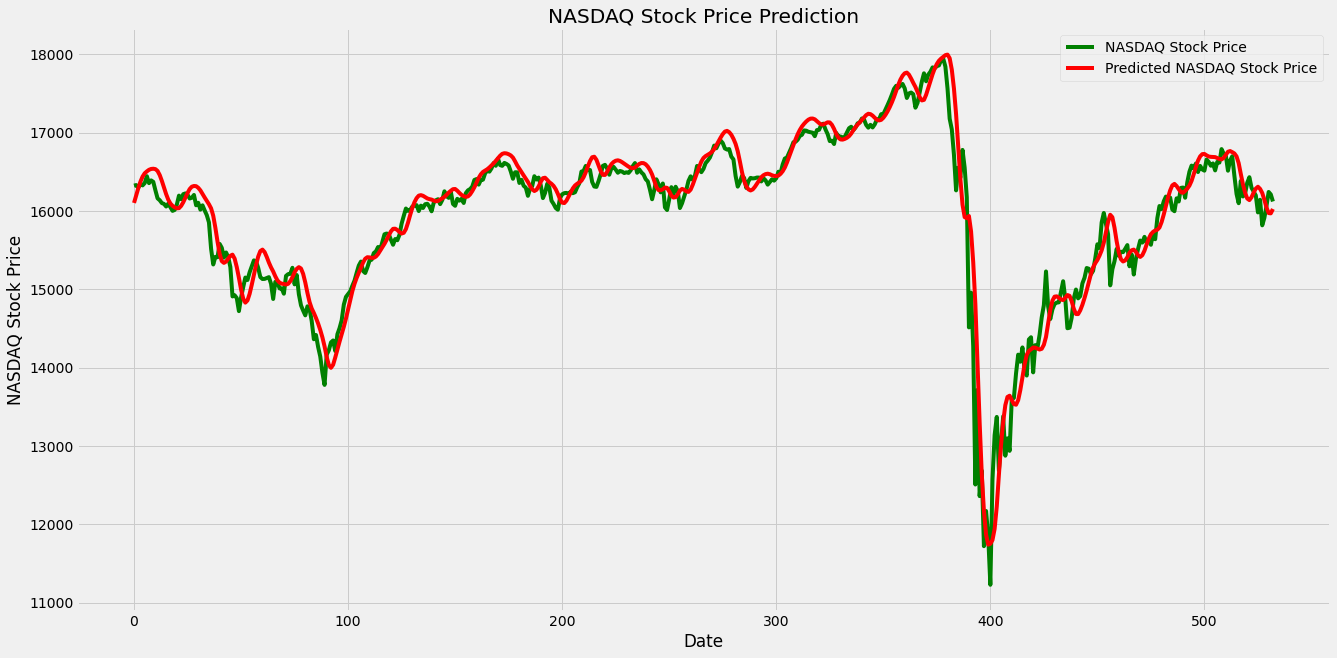

In [151]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'NASDAQ Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted NASDAQ Stock Price')
plt.title('NASDAQ Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Stock Price')
plt.legend()
plt.show()

In [74]:
rmse_predict= np.reshape(predicted_stock_price,541)

In [75]:
test["Close"].values.shape

(541,)

In [76]:
rmse_predict.shape

(541,)

In [77]:
#RMSE for LSTM Model
err_LSTM = rmse(test["Close"].values, rmse_predict)
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 396.96105468494505


In [124]:
#repeat the same process for TSX
df=pd.read_csv("GSPTSE_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [125]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [134]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 2600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [135]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [136]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
80/80 [==============================] - 13s 164ms/step - loss: 0.0242
Epoch 2/30
80/80 [==============================] - 11s 140ms/step - loss: 0.0065
Epoch 3/30
80/80 [==============================] - 11s 136ms/step - loss: 0.0059
Epoch 4/30
80/80 [==============================] - 11s 135ms/step - loss: 0.0060
Epoch 5/30
80/80 [==============================] - 11s 134ms/step - loss: 0.0050
Epoch 6/30
80/80 [==============================] - 11s 134ms/step - loss: 0.0046
Epoch 7/30
80/80 [==============================] - 11s 133ms/step - loss: 0.0039
Epoch 8/30
80/80 [==============================] - 11s 132ms/step - loss: 0.0040
Epoch 9/30
80/80 [==============================] - 10s 130ms/step - loss: 0.0037
Epoch 10/30
80/80 [==============================] - 10s 129ms/step - loss: 0.0033
Epoch 11/30
80/80 [==============================] - 10s 130ms/step - loss: 0.0032
Epoch 12/30
80/80 [==============================] - 10s 126ms/step - loss: 0.0030
Epoch 13/30
8

In [143]:
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 593):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [144]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

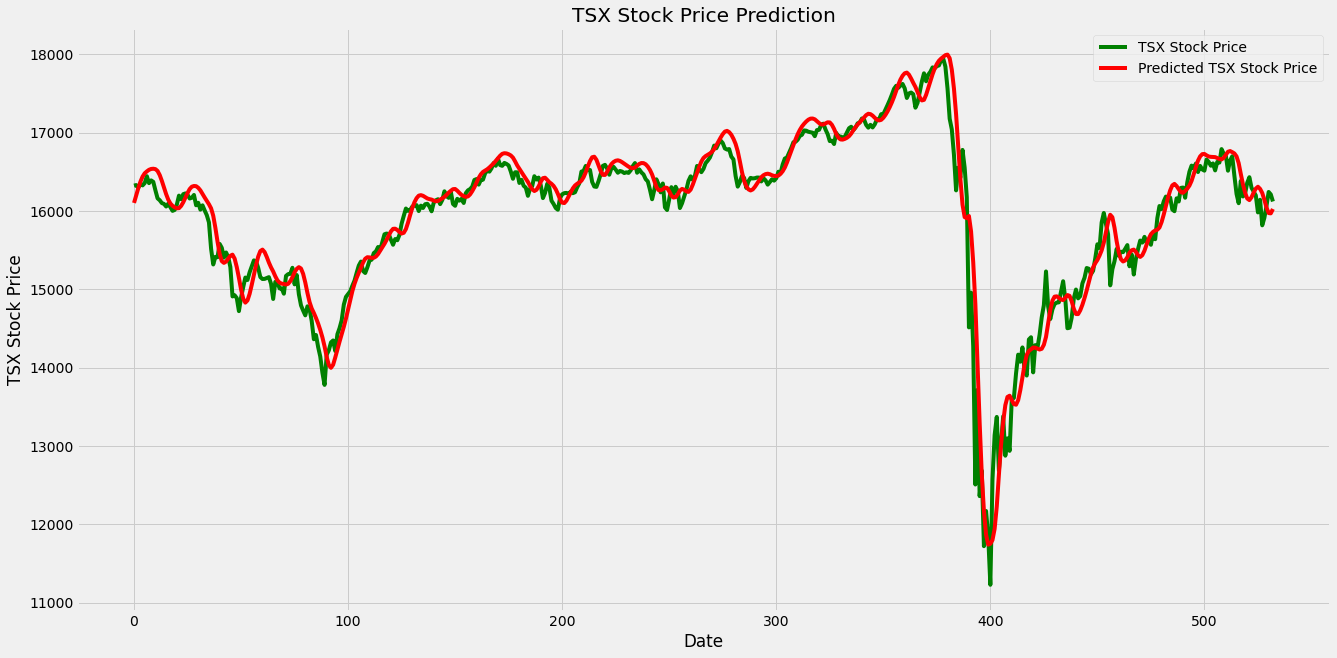

In [152]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'TSX Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted TSX Stock Price')
plt.title('TSX Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TSX Stock Price')
plt.legend()
plt.show()

In [147]:
rmse_predict= np.reshape(predicted_stock_price,533)

In [148]:
test["Close"].values.shape

(533,)

In [149]:
rmse_predict.shape

(533,)

In [150]:
#RMSE for LSTM Model
err_LSTM = rmse(test["Close"].values, rmse_predict)
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM 265.51210144690225
